In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#data = pd.read_csv("Data.tsv")

df = pd.read_csv('Data.tsv', sep='\t')
df.drop(df.columns[[0, 4]], axis=1, inplace = True)

df = df.rename(columns={'Your mean shoe size (In European Continental system)  ': "shoe_size",
                        'Which programme are you studying?': "program",
                        'Your height (in International inches)': "height"})


In [2]:
#Some data cleaning:
#Converting wrongly inserted cm to international inches: 
#column_name = "Your height (in International inches)"
#boolean_condition =df.iloc[:, 2]>107 (tallest guy ever measured 272cm = 107 inches)
#new_value = df.iloc[:, 2]/2.54

#df.loc[boolean_condition, column_name] = new_value
df.loc[df.iloc[:, 2]>107, ["height"]] = (df.iloc[:, 2]/2.54)

# Filter all rows for which the person wrongly inserted inches with comma and meaning the data:
#df["height"] = df["height"].apply(lambda x : df["height"].mean() if x < 20 else x)

# Filter all rows for which the person wrongly inserted inches with comma:
df.drop(df[df["height"] < 12].index, inplace = True) 

# Filter all rows for which the person wrongly inserted shoe size comma:
#df["shoe_size"] = df["shoe_size"].apply(lambda x : df["shoe_size"].mean() if x < 10 else x)

df.drop(df[df["shoe_size"] < 18].index, inplace = True) 

# converts the floats to ints in height column (needed for GaussianNB)
df["height"] = df["height"].apply(lambda x: int(x) if x == x else "")

#adding the attribute
m_f_list = []
for index, row in df.iterrows():
    if row["shoe_size"] < 42:
        m_f_list.append("F")
    else:
        m_f_list.append("M")
df["M_F"] = m_f_list


##to do: implement as costum transformer. 


In [3]:

df.corr().abs()[["height"]]

,height
shoe_size,0.822255
height,1.000000


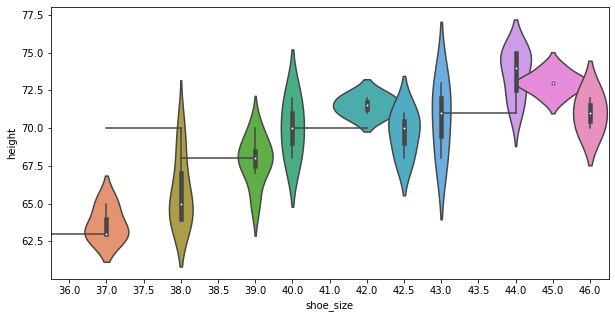

In [4]:


#The plot confirms the correlation between shoesize and height
fig, axs = plt.subplots(figsize=(10,5))
sns.violinplot(x="shoe_size", y="height", data=df, width=2)

In [5]:
# Defining the test and Fit data

# Separate target from predictors (Define X and Y)
y = df.iloc[:,2]#height
X = df.iloc[:,[0,1,3]]#shoe size, programme, 

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [6]:
# Defining the numerical and categorial columns

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 20 and X_train_full[cname].dtype == "object"]

#print("Categorial columns:"+str(categorical_cols))

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
#print("numerical columns:"+str(numerical_cols))

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

#Lets us peek which datatypes are categorial 
# and which are numerical in our integrated schema
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 0 to 49
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   shoe_size  47 non-null     float64
 1   program    47 non-null     object 
 2   height     47 non-null     int64  
 3   M_F        47 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ KB
None


In [7]:

# Preprocessing for numerical data

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='error'))])
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ],remainder = "passthrough")

#The oneHotEncoder did not work, for some reason...     
le = preprocessing.LabelEncoder()
df["program"] = le.fit_transform(df["program"].astype(str))
df["M_F"] = le.fit_transform(df["M_F"].astype(str))
    
    



In [8]:
# Training 
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

#Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline([('preprocessor', preprocessor),
                            ('model', model)
                           ])

my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['shoe_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                 

In [9]:
# Preprocessing of validation data, get predictions

from sklearn.metrics import mean_absolute_error
Y_hat = my_pipeline.predict(X_valid)
# Evaluate the model

#Lets us peek how preprocessing handled the datatypes
#print(df.info())

from sklearn.metrics import mean_absolute_error
Y_hat = my_pipeline.predict(X_valid)
# Evaluate the model
score = mean_absolute_error(y_valid, Y_hat)
print('MAE:', score)


MAE: 1.4


In [10]:
from sklearn import metrics
predict_test = my_pipeline.predict(X_valid)
print(metrics.accuracy_score(y_valid, predict_test))

0.4


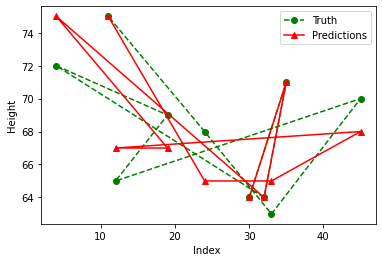

In [11]:
#X_valid = X_valid.reset_index(drop=True)
#y_valid = y_valid.reset_index(drop=True)

#plt.plot(X_valid['Your mean shoe size (In European Continental system)  '], y_valid, "--", label = "Truth")
#plt.plot(X_valid['Your mean shoe size (In European Continental system)  '], Y_hat, label = "Predictions")
plt.plot(X_valid.index, y_valid, color='green', marker='o', linestyle='dashed', label = "Truth")
plt.plot(X_valid.index, Y_hat, color='red', marker='^', linestyle='-', label = "Predictions")
plt.xlabel("Index ")
plt.ylabel("Height")
plt.legend()
plt.show()

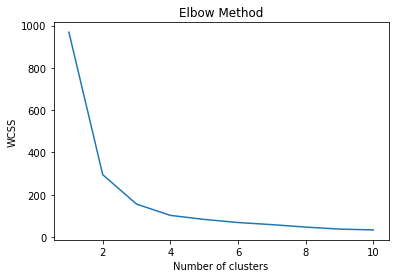

In [12]:
# To the clustering part:
from sklearn.cluster import KMeans

X_cluster = df[["shoe_size", "height", "M_F"]].values

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_cluster)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_cluster)
#kmeans.labels_
#print("*****", y_kmeans)

In [13]:
#km = KMeans(n_clusters=2, init="k-means++", n_init=10, max_iter=500) 
#y_kmeans = kmeans.fit_predict(X_cluster)
#y_kmeans df['clustersp'] =y_kmeans

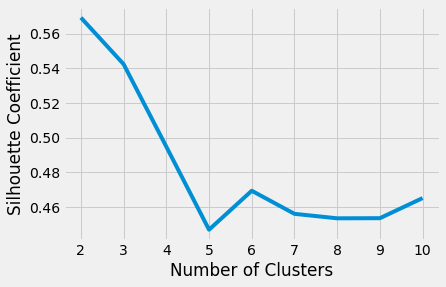

In [14]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
# Notice the start is at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k,)
    kmeans.fit(X_cluster)
    score = silhouette_score(X_cluster, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Silhouette Score(n=2): 0.5691477581864621


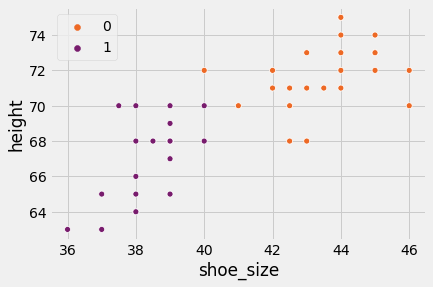

In [15]:
from sklearn.metrics import silhouette_score
print(f"Silhouette Score(n=2): {silhouette_score(X_cluster, y_kmeans)}")
sns.scatterplot(df["shoe_size"],df["height"],hue=y_kmeans,palette='inferno_r')